Forest Fires (forestfires.csv)

https://archive.ics.uci.edu/dataset/162/forest+fires


In [8]:
#contains multiple imports for ease of importing
%run import.py

#Set heatmap that runs through gamma and c parameters
%run grid_search_code.py

#reading csv
df_fires=pd.read_csv('forestfires.csv')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Question: How accurately can we predict the Drought Code of certain areas in Portugal? 

   X  Y  month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5      7    0  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4     10    5  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4     10    2  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6      7    0  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6      7    3  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


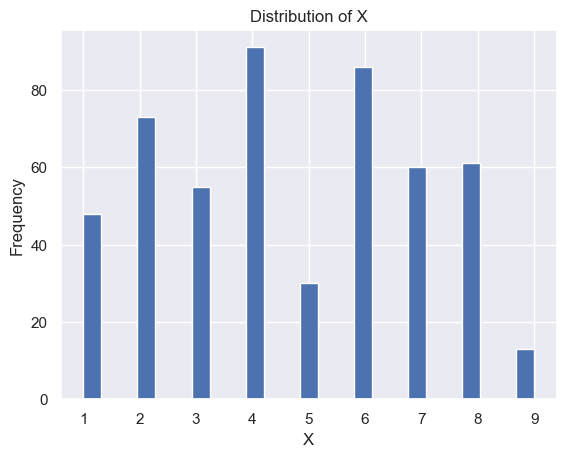

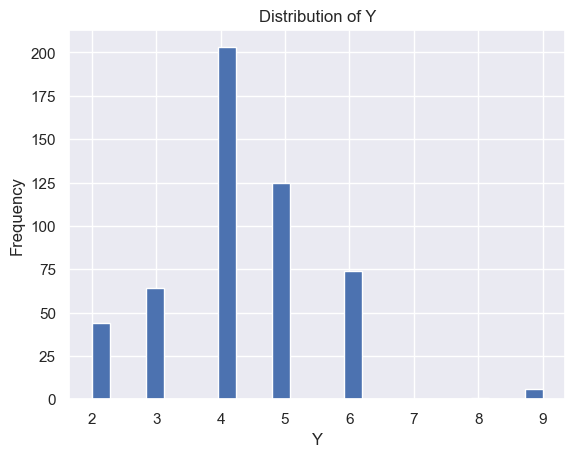

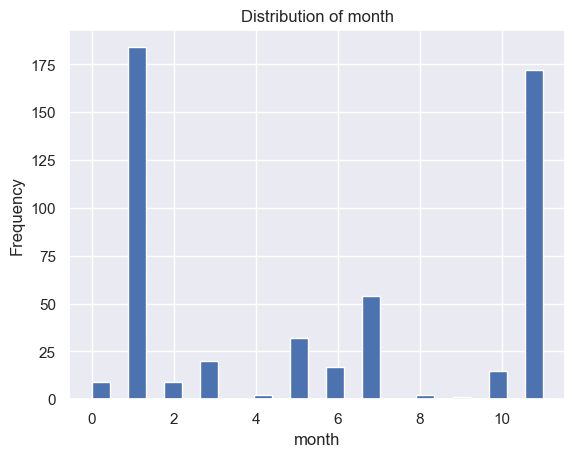

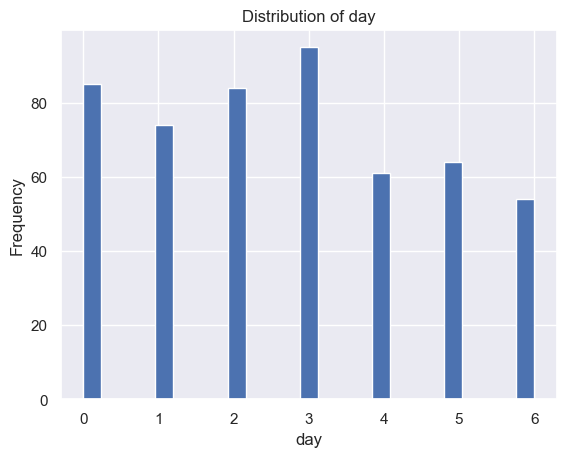

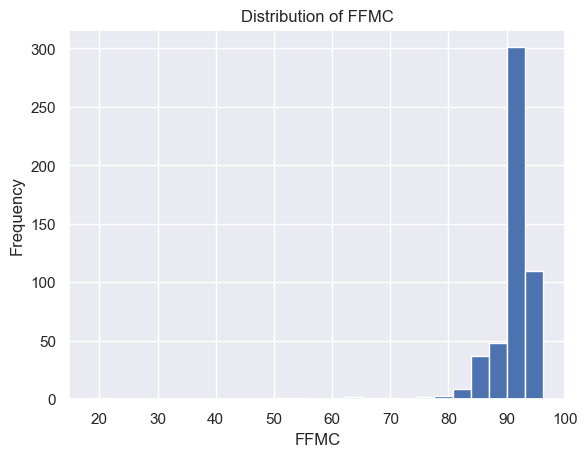

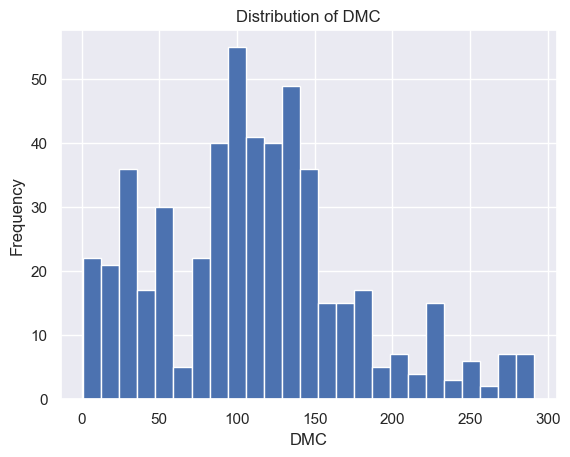

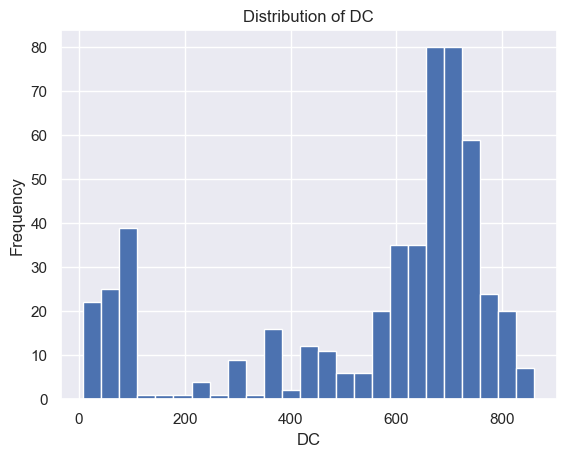

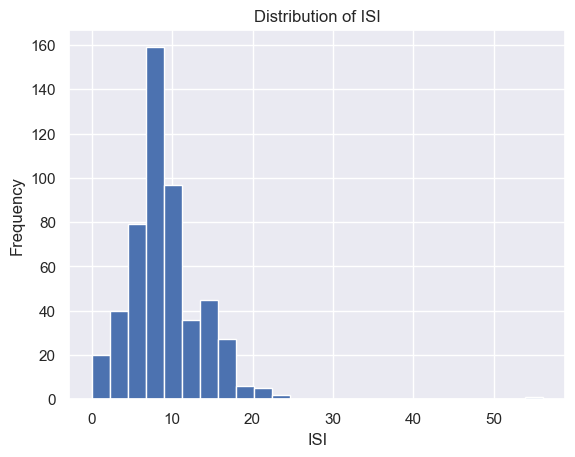

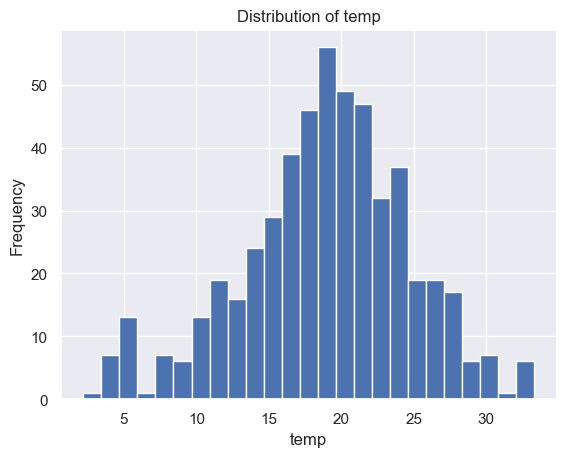

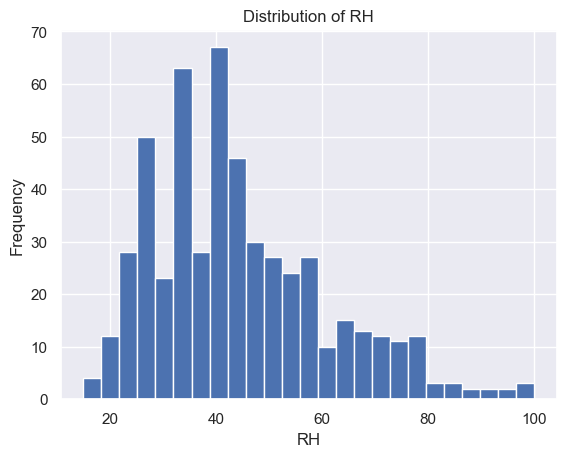

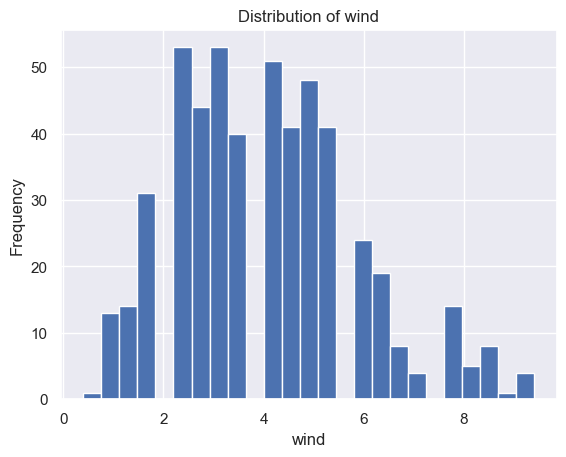

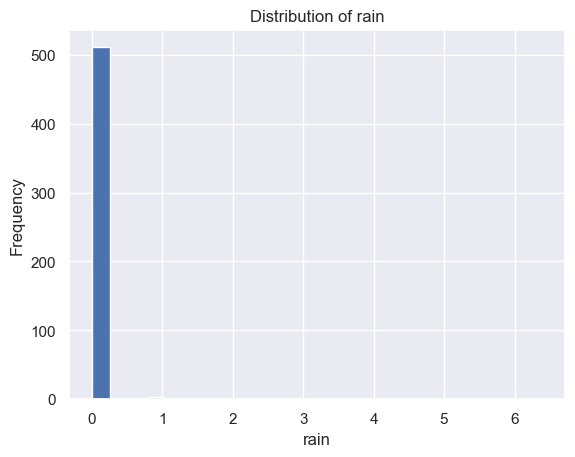

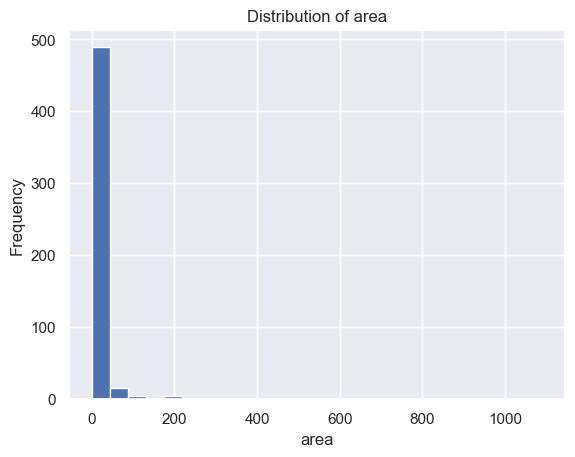

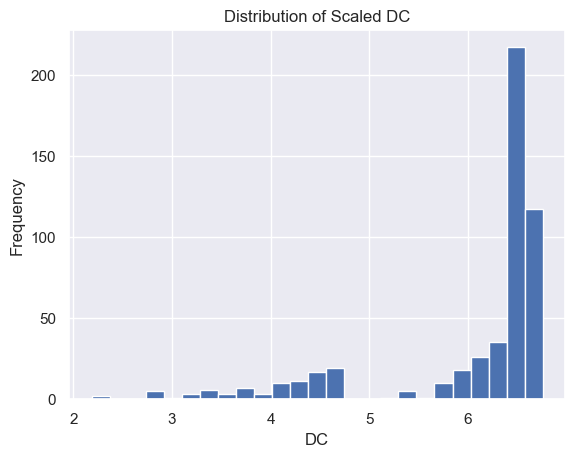

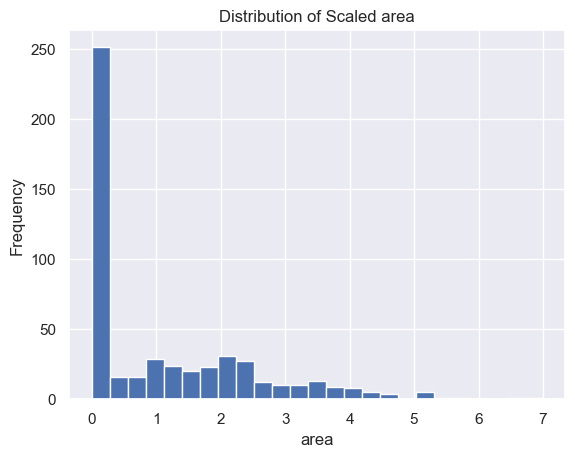

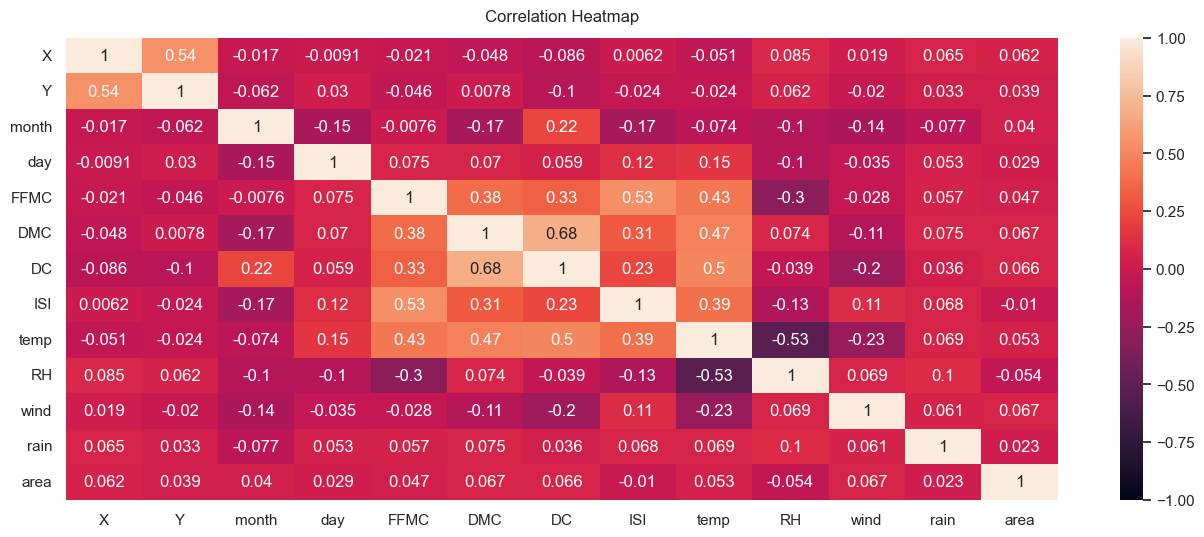

FFMC    0.330512
DMC     0.682192
DC      1.000000
temp    0.496208
Name: DC, dtype: float64


In [10]:
#cat coding variables into numeric
df_fires['month'] = df_fires['month'].astype('category')
df_fires['month'] = df_fires['month'].cat.codes
df_fires['day'] = df_fires['day'].astype('category')
df_fires['day'] = df_fires['day'].cat.codes

print(df_fires.head())

#checking the distribution of features 
for col in df_fires.columns:
    df_fires[col].hist(bins = 25)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    column = str(col)
    plt.title('Distribution of {}'.format(column))
    plt.show()

#copying dataframe
df_scale_fires = df_fires.copy()
df_best = df_fires.copy()
    
#scaled DC value, turns out to not help much
df_scale_fires['DC'] = np.log(df_scale_fires['DC'] + 1)

df_scale_fires['DC'].hist(bins = 25)
plt.xlabel('DC')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled DC')
plt.show()

#scaled area value, reccommended to do 
df_scale_fires['area'] = np.log(df_scale_fires['area'] + 1)

df_scale_fires['area'].hist(bins = 25)
plt.xlabel('area')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled area')
plt.show()

#scaling the only feature worth scaling
df_best['area'] = np.log(df_best['area'] + 1)

#heatmap of correlation
plt.figure(figsize=(16, 6))
hmap = sns.heatmap(df_best.corr(), vmin=-1, vmax=1, annot=True)
hmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

#storing correlation
corr_dat = abs(df_best.corr())

#picking a threshold to base the correlation with Drought Code
corr_target = corr_dat["DC"]
features = corr_target[corr_target>0.30] #had to move up as model was overfitting

print(features)

df = pd.DataFrame()
n = 0

#creating a data frame containing the columns from the attributes with the higher correlation
for i in features.index:
    val = df_best[i].tolist()
    df.insert(n, i, val)
    n = n+1


Test set score: 0.63
Train set score: 0.74
Best parameters: {'C': 10000, 'gamma': 0.001}
Best cross-validation score: 0.69
Best estimator:
SVR(C=10000, gamma=0.001)


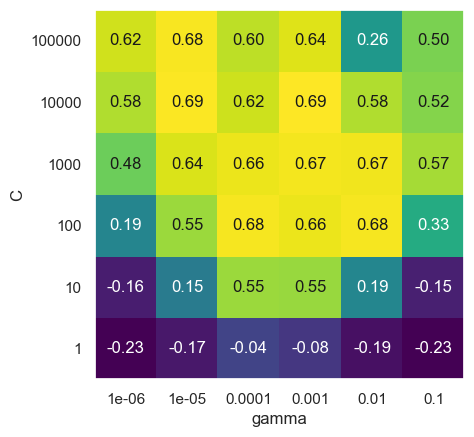

In [11]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVR

#selecting x and y
x = df.drop(['DC'], axis = 1)
y = df['DC']

#grid search and cross validation test
param_grid = {'C': [1, 10, 100, 1000, 10000, 100000], 'gamma': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]}
grid_search = GridSearchCV(SVR(), param_grid, cv=5,return_train_score=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Train set score: {:.2f}".format(grid_search.score(X_train, y_train)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

#displaying mean test scores from cross validation
results = pd.DataFrame(grid_search.cv_results_) 
scores =  np.array(results.mean_test_score).reshape(6,6)
print(heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap="viridis"))

Analysis: \
During the exploritory analysis there were a few features that needed to be adjusted in order to accurately run a correlation test. Month and day needed to be cat coded into numbers. There were also a few features that possibly needed to be scaled so they were distributed more approprietly, these features include FFMC, DC, DMC, and area. After scaling and re-graphing them the a the only two features I was worried about were the area and DC features. The area feature needing to be scaled makes sense as in the description for the data they mention needing to do this. The description did not mention needing to do anything with the DC value so I attempted to run the grid search test with the scaled data however, when I looked at the correlation after scaling it did not benefit much if at all. With this in mind I decided to only scale the area data which for this question never gets used anyway. For the next step I created a heat map in order to see all the correlations, then run a correlation target to pick the ones that were high enough to be useful in the testing. The features chosen were FFMC DMC and Temp. \
\
The final step was to run the grid search on the scaled data to find and test the best parameters in order to increase accuracy. My original attempt resulted in very high test scores. However, this look as though the model was less flexible and there was potential for over fitting data. To solve this I increased the threshold for my target data and found that it gave much more reasonable results as seen above. SVR is compatable with gamma and C paramters so we can use those incrementing each one by a power of 10. Then running through these values and fitting the data we can check the test score, train score, and best cross validation score. It is important to include the training score as it makes it easier to see if your model is over fitting. The last thing to do is create a heatmap of the average cross validation scores over the gamma and c parameters. Looking at the heatmap we can see the best result being at a C of 10000 and a gamma of.001. Looking around that square shows a drop off meaning we should be at a peak, there is another square with the same value which means it is close to the highest value but must be slightly lower.

My original question was if we can accurately predict the area a fire will burn? After creating the heatmap for the features it is obviouse that none of the other features are correlated with this feature strongly enough to really do any predictions with it. \
Example (unscaled):

X       0.061995
DMC     0.067153
DC      0.066360
wind    0.066973
area    1.000000
Name: area, dtype: float64
Test set score: -0.03
Train set score: 0.05
Best parameters: {'C': 10, 'gamma': 100}
Best cross-validation score: -0.04
Best estimator:
SVR(C=10, gamma=100)


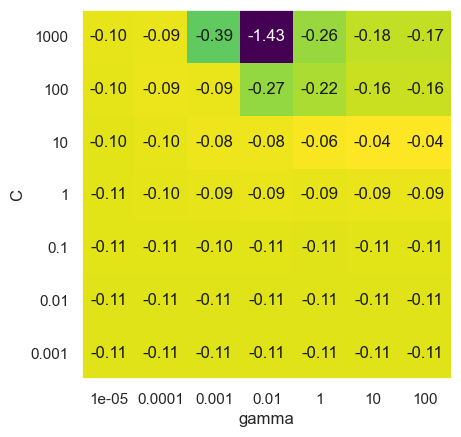

In [12]:
corr_target = corr_dat["area"]
features = corr_target[corr_target>0.06] #not many attributes to choose from so threshold is low 

print(features)

df_Unsc = pd.DataFrame()
n = 0

#creating a data frame containing the columns from the attributes with the higher correlation
for i in features.index:
    val = df_fires[i].tolist()
    df_Unsc.insert(n, i, val)
    n = n+1
    
x = df_Unsc.drop(['area'], axis = 1)
#data['area'] = math.exp(data['area']) - 1
y = df_Unsc['area']

param_grid = {'C': [.001, .01, .1, 1, 10, 100, 1000], 'gamma': [.00001, .0001, .001, .01, 1, 10, 100]}
grid_search = GridSearchCV(SVR(), param_grid, cv=5,return_train_score=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Train set score: {:.2f}".format(grid_search.score(X_train, y_train)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

results = pd.DataFrame(grid_search.cv_results_) 
#display(results.head())
scores =  np.array(results.mean_test_score).reshape(7,7)
print(heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap="viridis"))

Even when using the scaled data, the model has a hard time getting high accuracies from testing. \
Example (scaled):

X       0.061995
DMC     0.067153
DC      0.066360
wind    0.066973
area    1.000000
Name: area, dtype: float64
Test set score: -0.07
Train set score: 0.93
Best parameters: {'C': 1000, 'gamma': 100}
Best cross-validation score: -0.06
Best estimator:
SVR(C=1000, gamma=100)


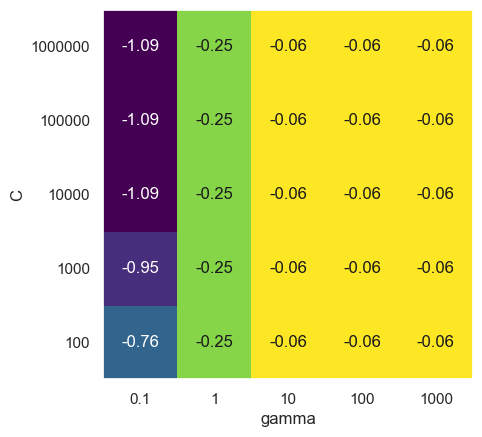

In [13]:
corr_dat_Scaled = abs(df_best.corr())

corr_target_Scaled = corr_dat_Scaled["area"]
features_Scaled = corr_target_Scaled[corr_target_Scaled>0.06] #not many attributes to choose from so threshold is low 

print(features_Scaled)

df_Scal = pd.DataFrame()
n = 0

#creating a data frame containing the columns from the attributes with the higher correlation
for i in features.index:
    val = df_best[i].tolist()
    df_Scal.insert(n, i, val)
    n = n+1
    
x = df_Scal.drop(['area'], axis = 1)
#data['area'] = math.exp(data['area']) - 1
y = df_Scal['area']

param_grid = {'C': [100, 1000, 10000, 100000, 1000000], 'gamma': [.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(SVR(), param_grid, cv=10,return_train_score=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Train set score: {:.2f}".format(grid_search.score(X_train, y_train)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

results = pd.DataFrame(grid_search.cv_results_) 
#display(results.head())
scores =  np.array(results.mean_test_score).reshape(5,5)
print(heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap="viridis"))

To answer the question, "can we accurately predict the area a fire will burn?" by utilizing scaling and finding optimal parameters while using Support Vector Regression, No. It is possible that with more feature manipulation and possibly a different model it could be done however, predicting the Drought Code using SVR seems to be a more promising task.